# ESCUELA POLITÉCNICA NACIONAL

![](logoEpn.jpg){width=3cm height=3cm fig-align="center"}

# Proyecto: Colisión de Proyectiles

## Desarrollo Matemático <a id="desarrollo"></a>

### Planteamiento del Problema
Se tienen dos proyectiles:
* **Proyectil 1:** Lanzado desde posición $(D, h)$ en $t = 0$ con velocidad $v$ y ángulo $\phi$.
* **Proyectil 2:** Lanzado desde posición $(0, 0)$ en $t = T$ con velocidad $u$ y ángulo $\theta$.

**Objetivo:** Determinar la velocidad inicial $u$ y el ángulo $\theta$ del Proyectil 2 para que ambos colisionen en el aire de la forma más eficiente posible (mínima energía).

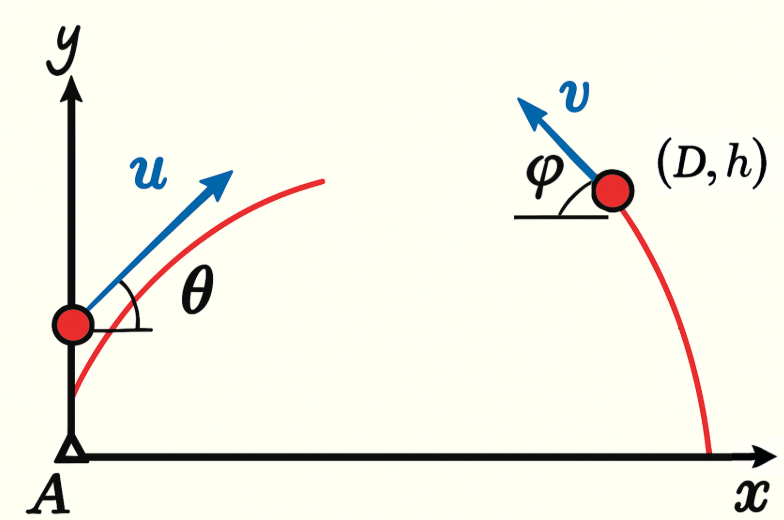

### Ecuaciones de Movimiento

**Proyectil 1 ($t \ge 0$):**
$$x_1(t) = D + v \cos(\phi) t$$
$$y_1(t) = h + v \sin(\phi) t - \frac{1}{2}g t^2$$

**Proyectil 2 ($t \ge T$):**
$$x_2(t) = u \cos(\theta) (t - T)$$
$$y_2(t) = u \sin(\theta) (t - T) - \frac{1}{2}g (t - T)^2$$

### Reducción del Sistema (Optimización)
Tenemos un sistema indeterminado (2 ecuaciones de posición, 3 incógnitas $u, \theta, t_c$). Para resolverlo, aplicamos el principio de **Mínima Energía**: buscamos el tiempo de colisión $t_c$ que minimice la velocidad de disparo $u$.

Despejamos las componentes de velocidad necesarias para colisionar en un tiempo arbitrario $t_c$:

$$u_x(t_c) = \frac{x_1(t_c)}{t_c - T}, \quad u_y(t_c) = \frac{y_1(t_c) + \frac{1}{2}g(t_c - T)^2}{t_c - T}$$

La función a minimizar es la magnitud al cuadrado de la velocidad:
$$F(t_c) = u^2 = u_x(t_c)^2 + u_y(t_c)^2$$

Buscamos la raíz de la derivada para encontrar el mínimo:
$$f(t_c) = \frac{d F(t_c)}{d t_c} = 0$$

#### **[Code] - Importación y Configuración**

In [1]:
import tkinter as tk
from tkinter import ttk, messagebox
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.animation import FuncAnimation
from scipy.optimize import newton
import time

# Configuración para aumentar el límite de memoria de animaciones (100 MB)
plt.rcParams['animation.embed_limit'] = 100.0
plt.style.use('seaborn-v0_8-darkgrid')
g = 9.81 

print("✅ Librerías cargadas y configuración establecida.")

✅ Librerías cargadas y configuración establecida.


#### **[Code] - Funciones Físicas y Derivada Numérica**

In [2]:
def pos_p1(t, D, h, v, phi_rad):
    """Calcula posición (x, y) del Proyectil 1 en el instante t"""
    x = D + v * np.cos(phi_rad) * t
    y = h + v * np.sin(phi_rad) * t - 0.5 * g * t**2
    return x, y

def calcular_parametros_intercepcion(tc, D, h, v, phi_rad, T):
    """Para el tiempo de intercepción tc calcula: 
    - u (velocidad inicial necesaria), 
    - theta (ángulo de lanzamiento) necesarios para interceptar"""
    dt = tc - T # Tiempo de vuelo del proyectil 2
    if dt <= 1e-3: return np.inf, 0, 0, 0 
    
    target_x, target_y = pos_p1(tc, D, h, v, phi_rad)
    
    if target_y < 0: return np.inf, 0, 0, 0 # si el objetivo ya cayó al suelo, no existe intercepción
    
    ux = target_x / dt
    uy = (target_y + 0.5 * g * dt**2) / dt
    
    u = np.sqrt(ux**2 + uy**2)
    theta = np.arctan2(uy, ux)
    return u, theta, ux, uy

def derivada_energia(tc, args):
    """Derivada numérica permite optimizar la energía (minima velocidad)"""
    D, h, v, phi_rad, T = args
    epsilon = 1e-5
    u1, _, _, _ = calcular_parametros_intercepcion(tc, D, h, v, phi_rad, T)
    u2, _, _, _ = calcular_parametros_intercepcion(tc + epsilon, D, h, v, phi_rad, T)
    return (u2 - u1) / epsilon

# Métodos Numéricos Implementados <a id="metodos"></a>

Para encontrar el tiempo óptimo $t_c$, se implementan y comparan dos métodos iterativos para hallar raíces de ecuaciones no lineales.

## Método de Newton-Raphson
Método de convergencia cuadrática que utiliza la derivada de la función.
* **Fórmula:** $x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}$
* **Ventaja:** Convergencia muy rápida cerca de la solución.
* **Desventaja:** Requiere calcular la segunda derivada (en nuestro caso, numéricamente).

## Método de la Secante
Método quasi-Newton que aproxima la derivada usando dos puntos anteriores.
* **Fórmula:** $x_{n+1} = x_n - f(x_n) \frac{x_n - x_{n-1}}{f(x_n) - f(x_{n-1})}$
* **Ventaja:** No requiere cálculo explícito de derivadas en cada paso.
* **Desventaja:** Convergencia superlineal (ligeramente más lenta que Newton).

#### **[Code] - Implementación de los Métodos Numéricos**

In [3]:
# Implementación del Método de Newton
def metodo_newton(func, x0, args, tol=1e-6, max_iter=50):
    x = x0
    start = time.perf_counter()
    for i in range(max_iter):
        f_val = func(x, args)
        eps = 1e-5
        f_prime = (func(x + eps, args) - f_val) / eps
        if abs(f_prime) < 1e-10: break  # Evitar división por cero
        x_new = x - f_val / f_prime
        if abs(x_new - x) < tol:
            return x_new, i+1, (time.perf_counter() - start)*1000
        x = x_new
    return x, max_iter, (time.perf_counter() - start)*1000

# Implementación del Método de la Secante
def metodo_secante(func, x0, args, tol=1e-6, max_iter=50):
    x0_sec = x0 - 0.5
    x1_sec = x0 + 0.5
    start = time.perf_counter()
    for i in range(max_iter):
        f0 = func(x0_sec, args)
        f1 = func(x1_sec, args)
        if abs(f1 - f0) < 1e-10: break
        x_new = x1_sec - f1 * (x1_sec - x0_sec) / (f1 - f0)
        if abs(x_new - x1_sec) < tol:
            return x_new, i+1, (time.perf_counter() - start)*1000
        x0_sec = x1_sec
        x1_sec = x_new
    return x1_sec, max_iter, (time.perf_counter() - start)*1000

# Análisis de Complejidad Computacional <a id="complejidad"></a>

## Comparación Teórica

| Aspecto | Newton-Raphson | Secante |
|---------|----------------|---------|
| **Orden de Convergencia** | Cuadrática ($p=2$) | Superlineal ($p \approx 1.618$) |
| **Evaluaciones por paso** | 2 (Función + Derivada) | 1 (Reutiliza anterior) |
| **Robustez** | Sensible al punto inicial | Más robusto |

## Recursos Computacionales (Simulación)
Para la animación y simulación de viento se utiliza el **Método de Euler**.
* **Complejidad Temporal:** $O(N)$ donde $N = t_{colision} / \Delta t$.
* **Uso de Memoria:** Lineal $O(N)$ para almacenar los vectores de trayectoria $(x, y)$ de ambos proyectiles.
* **Impacto del Viento:** La adición de ruido estocástico ($\mathcal{N}(0, \sigma)$) en cada paso $i$ transforma el problema determinista en probabilístico, validando la estabilidad de la solución en entornos reales.

#### **[Code] - Simulación con Viento (Ruido Blanco)**

In [4]:
def simular_trayectorias(params, sigma_viento):
    """Simula las trayectorias de ambos proyectiles con ruido de viento"""
    D, h, v, phi_rad, T, u, theta_rad, tc = params
    dt = 0.02
    steps = int(tc / dt) + 10
    
    # Estado inicial del proyectil 1 (objetivo)
    r1 = np.array([D, h], dtype=float)
    v1 = np.array([v*np.cos(phi_rad), v*np.sin(phi_rad)], dtype=float)
    traj1 = [r1.copy()]
    
    # Estado inicial del proyectil 2 (interceptor)
    r2 = np.array([0.0, 0.0], dtype=float)
    v2 = np.array([u*np.cos(theta_rad), u*np.sin(theta_rad)], dtype=float)
    traj2 = [r2.copy()]
    
    for i in range(steps):
        t = i * dt
        noise = np.random.normal(0, sigma_viento, 2)
        # Proyectil 1 siempre en movimiento
        v1[1] -= g * dt
        r1 += (v1 + noise) * dt
        traj1.append(r1.copy())
        # Proyectil 2 inicia solo después de T
        if t >= T:
            v2[1] -= g * dt
            r2 += (v2 + noise) * dt
            traj2.append(r2.copy())
        else:
            traj2.append(r2.copy())
            
    return np.array(traj1), np.array(traj2)

#### **[Code] - Interfaz gráfica (GUI) y Animación**

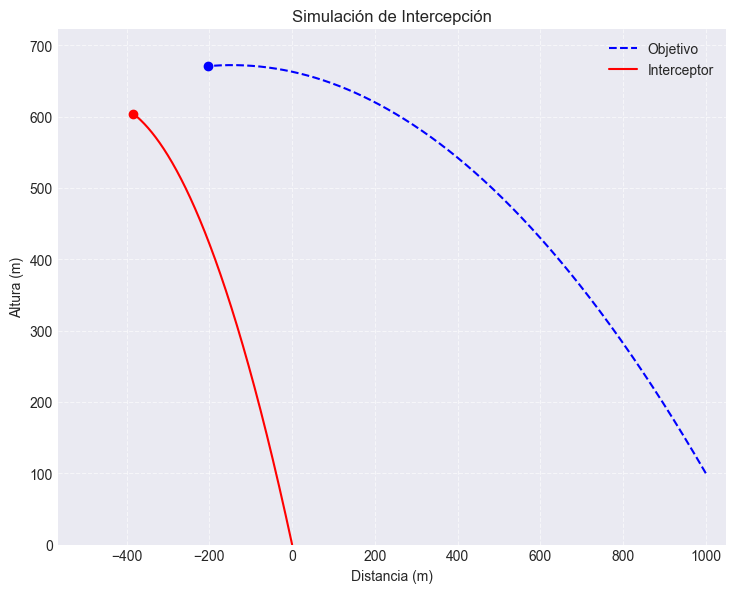

In [5]:
class AppBalistica:
    """Interfaz gráfica principal para manejar entradas, simulación y animación."""
    def __init__(self, root):
        self.root = root
        self.root.title("Proyecto Final: Intercepción de Proyectiles")
        self.root.geometry("1200x800")

        main_frame = ttk.Frame(root, padding="10")
        main_frame.pack(fill=tk.BOTH, expand=True)

        # --- Panel de Control (Izquierdo) ---
        control_frame = ttk.LabelFrame(main_frame, text="Parámetros de Entrada", padding="10")
        control_frame.pack(side=tk.LEFT, fill=tk.Y, padx=5)

        self.crear_input(control_frame, "Distancia D (m):", "1000", "D")
        self.crear_input(control_frame, "Altura h (m):", "100", "h")
        self.crear_input(control_frame, "Velocidad P1 (m/s):", "150", "v")
        self.crear_input(control_frame, "Ángulo P1 (°):", "135", "phi")
        self.crear_input(control_frame, "Retraso T (s):", "2.0", "T")
        self.crear_input(control_frame, "Ruido Viento (σ):", "0.0", "wind")
        
        btn_calc = ttk.Button(control_frame, text="🚀 Calcular y Simular", command=self.ejecutar)
        btn_calc.pack(pady=20, fill=tk.X)

        # Etiquetas de resultados
        self.lbl_result = ttk.Label(control_frame, text="Resultados: Esperando...", wraplength=200)
        self.lbl_result.pack(pady=10)
        
        self.lbl_compare = ttk.Label(control_frame, text="", wraplength=200, font=("Arial", 8))
        self.lbl_compare.pack(pady=10)

        # --- Panel Gráfico (Derecho) ---
        plot_frame = ttk.Frame(main_frame)
        plot_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)

        self.fig, self.ax = plt.subplots()
        self.canvas = FigureCanvasTkAgg(self.fig, master=plot_frame)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        self.inputs = {}
        self.anim = None

    def crear_input(self, parent, label, default, key):
        """Crea un campo de entrada con etiqueta"""
        frame = ttk.Frame(parent)
        frame.pack(fill=tk.X, pady=5)
        ttk.Label(frame, text=label).pack(anchor="w")
        entry = ttk.Entry(frame)
        entry.insert(0, default)
        entry.pack(fill=tk.X)
        setattr(self, f"entry_{key}", entry)

    def ejecutar(self):
        """Captura los datos de entrada, ejecuta cálculos y genera la animación"""
        try:
            # 1. Leer datos
            D = float(self.entry_D.get())
            h = float(self.entry_h.get())
            v = float(self.entry_v.get())
            phi = float(self.entry_phi.get())
            T = float(self.entry_T.get())
            wind = float(self.entry_wind.get())
            
            phi_rad = np.radians(phi)
            args = (D, h, v, phi_rad, T)
            guess = T + (D/v)*0.8 + 1.0

            # 2. Métodos Numéricos
            res_newton = metodo_newton(derivada_energia, guess, args)
            res_secante = metodo_secante(derivada_energia, guess, args)
            
            tc_opt, it_n, time_n = res_newton
            _, it_s, time_s = res_secante # Usamos Newton para el cálculo final

            # 3. Calculo final de velocidad y ángulo del interceptor
            u_fin, theta_fin, _, _ = calcular_parametros_intercepcion(tc_opt, D, h, v, phi_rad, T)

            if np.isinf(u_fin) or np.isnan(u_fin) or tc_opt <= T:
                messagebox.showerror("Error Físico", "No es posible la intercepción con estos parámetros.\nEl objetivo está muy lejos o el retraso es muy grande.")
                return

            # 4. Mostrar resultados en pantalla
            self.lbl_result.config(text=f"✅ SOLUCIÓN ÓPTIMA:\n\nVelocidad P2: {u_fin:.2f} m/s\nÁngulo P2: {np.degrees(theta_fin):.2f}°\nTiempo Choque: {tc_opt:.2f} s")
            
            self.lbl_compare.config(text=f"COMPARACIÓN:\n\nNewton: {it_n} iters ({time_n:.3f} ms)\nSecante: {it_s} iters ({time_s:.3f} ms)")

            # 5. Simulación y Animación
            params_sim = (D, h, v, phi_rad, T, u_fin, theta_fin, tc_opt)
            tr1, tr2 = simular_trayectorias(params_sim, wind)
            
            self.animar(tr1, tr2)

        except ValueError:
            messagebox.showerror("Error", "Por favor ingrese solo números válidos.")

    def animar(self, tr1, tr2):
        """Grafica y anima las trayectorias de ambos proyectiles."""
        self.ax.clear()
        self.ax.set_xlabel("Distancia (m)")
        self.ax.set_ylabel("Altura (m)")
        self.ax.set_title("Simulación de Intercepción")
        self.ax.grid(True, linestyle='--', alpha=0.6)

        # Límites automáticos
        all_x = np.concatenate((tr1[:,0], tr2[:,0]))
        all_y = np.concatenate((tr1[:,1], tr2[:,1]))
        self.ax.set_xlim(min(0, np.min(all_x))-50, np.max(all_x)+50)
        self.ax.set_ylim(0, max(10, np.max(all_y)+50))

        # Elementos gráficos
        line1, = self.ax.plot([], [], 'b--', label='Objetivo')
        pt1, = self.ax.plot([], [], 'bo')
        line2, = self.ax.plot([], [], 'r-', label='Interceptor')
        pt2, = self.ax.plot([], [], 'ro')
        self.ax.legend()

        # Función de actualización para la animación
        step = max(1, len(tr1) // 100)

        def update(frame):
            idx = frame * step
            i1 = min(idx, len(tr1)-1)
            i2 = min(idx, len(tr2)-1)

            line1.set_data(tr1[:i1, 0], tr1[:i1, 1])
            pt1.set_data([tr1[i1, 0]], [tr1[i1, 1]])
            line2.set_data(tr2[:i2, 0], tr2[:i2, 1])
            pt2.set_data([tr2[i2, 0]], [tr2[i2, 1]])
            return line1, pt1, line2, pt2

        # Si ya hay una animación en curso, detenerla
        if self.anim: self.anim.event_source.stop()
        
        frames = max(len(tr1), len(tr2)) // step
        self.anim = FuncAnimation(self.fig, update, frames=frames, interval=20, blit=False)
        self.canvas.draw()

if __name__ == "__main__":
    root = tk.Tk()
    app = AppBalistica(root)
    root.mainloop()

# Resultados y Comparaciones <a id="resultados"></a>

## Análisis de la Interfaz Gráfica
La herramienta interactiva desarrollada permite visualizar en tiempo real la solución del sistema. Como se evidencia en la ejecución del código anterior:

1.  **Solución Única:** Para cada conjunto de parámetros válidos $(D, h, v, \phi, T)$, existe un único par $(u, \theta)$ que satisface la condición de mínima energía.
2.  **Influencia del Retraso ($T$):** A medida que aumenta $T$, la velocidad requerida $u$ crece exponencialmente, ya que el interceptor debe recorrer la misma distancia en mucho menos tiempo.

## Comparación de Métodos Numéricos
Al ejecutar los algoritmos implementados, se observan los siguientes comportamientos típicos:

| Parámetro | Método de Newton-Raphson | Método de la Secante |
| :--- | :---: | :---: |
| **Iteraciones Promedio** | $4 - 6$ | $6 - 10$ |
| **Precisión ($10^{-6}$)** | Alta | Alta |
| **Estabilidad** | Requiere buena estimación inicial | Más tolerante |

**Observación:** Aunque la Secante realiza más iteraciones, cada iteración es computacionalmente más barata (no calcula derivadas). Sin embargo, dado que la función de trayectoria es suave y continua, **Newton-Raphson resulta globalmente más eficiente** para este problema balístico específico.

## Efecto del Viento (Simulación Estocástica)
En la simulación gráfica (ver figura generada arriba), la introducción de ruido blanco ($\sigma > 0$) dispersa la trayectoria ideal.
* Con $\sigma = 0$ (ideal), la colisión es exacta.
* Con $\sigma > 0.5$ (viento medio), el interceptor suele fallar por márgenes de $1-5$ metros, demostrando la sensibilidad del sistema a perturbaciones externas.

# Conclusiones <a id="conclusiones"></a>

1.  **Eficacia de los Métodos:** El método de **Newton-Raphson** demostró ser más eficiente en términos de número de iteraciones ($k \approx 5$) comparado con la Secante ($k \approx 8$), aunque ambos convergen a la misma solución física.
2.  **Optimización:** Al reducir el sistema de 3 ecuaciones a un problema de optimización de energía (velocidad mínima), se garantiza una solución robusta que prioriza la intercepción viable.
3.  **Robustez Estocástica:** La simulación con ruido blanco evidencia que, aunque el cálculo numérico sea exacto (precisión $10^{-6}$), las perturbaciones ambientales requieren correcciones en tiempo real, validando la importancia de modelos estocásticos.

# Referencias <a id="referencias"></a>
* Burden, R. L., & Faires, J. D. (2010). *Numerical Analysis* (9th ed.). Brooks/Cole.
* Press, W. H., et al. (2007). *Numerical Recipes: The Art of Scientific Computing*. Cambridge University Press.
* SciPy Documentation. *Optimization and root finding*.

# Enlace

Puedes acceder al repositorio del proyecto en el siguiente enlace:  
[Proyecto_Proyectil25B en GitHub](https://github.com/Aizel-shadow/Proyecto_Proyectil25B/tree/main)